# Creating data Generators for Real World Image datasets

Tensorflow tutorials will serve as introduction to gain high level undestanding of the concepts on Neural Networks and machine learning. However it is sometimes difficult to translate that knowledge to real world applications if we do not know how the necessary tools needed for the task at Hand.

For computer vision applications, we generally deal with datasets of large volumes of images, that cannot fit entirely on our memory. Hence the need of **image generators** 


In [1]:
!git clone https://github.com/hector6298/ASU_ConvNet_workshops.git

Cloning into 'ASU_ConvNet_workshops'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 50 (delta 19), reused 43 (delta 14), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [2]:
from tensorflow.keras.utils import Sequence

This generators are iterables that execute some procedures on each iteration (i.e when calling next() on the generator or iterating on a for loop). Keras ImageDataGenerator needs to implement __next__(), __len__(), and __getitem__() to work properly

## Preparing the data (COVIDx dataset)

Do not mind the code below, just imagine a black box that prepares all the data

In [3]:
!sh "/content/ASU_ConvNet_workshops/dataset_prep/dataset_prep.sh"

from ASU_ConvNet_workshops.dataset_prep.dataset_utils import generate_train_test_filenames
annotations_train, annotations_test = generate_train_test_filenames()

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6726.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6727.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6728.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6729.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-673.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6730.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6731.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6732.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6733.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6734.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6735.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6736.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6737.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6738.png  
  inflating:

**Lets take a look at the distribution of classes**

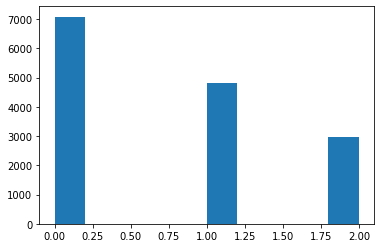

In [4]:
map = {"normal": 0, "pneumonia": 1, "COVID-19": 2}
catlist = [annotations_train[i][2] for i in range(len(annotations_train))]
numlist = [map[cat] for cat in catlist]

import matplotlib.pyplot as plt

_ = plt.hist(numlist)

We can clearly see that there is an imbalace between classes. Most machine learning algorithms assume data equally distributed. So when we have a class imbalance, the machine learning classifier **tends to be more biased towards the majority class**

## Define Image Generators

In [5]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 64
INPUT_SIZE = 224
NCLASSES = 3
INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE, NCLASSES)
ENHANCE = True
TRAINFILE = '/content/train_split_v3.txt'
TESTFILE = '/content/test_split_v3.txt'
DATADIR = '/content/data'

**Image utility functions**

In [6]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, top_percent, size, enhance=False):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    img = central_crop(img)
    img = cv2.resize(img, (size, size))
    if enhance:
      img = xray_enhance(img)
    return img

def xray_enhance(img):
  gaussian_3 = cv2.GaussianBlur(img, (3,3), 10.0)
  unsharp_image = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
  return unsharp_image

**DataAugmentation**

Since classes are unbalanced, First we need to figure a mechanism as to retrieve the same amount of samples per class on each batch. One quick solution is to just take random samples with replacement for the minority class. 

Then, we need to artifitially augment the dataset by applying transformations to the images, mainly: 

- rotations
- traslations
- Brightness changes
- Zoom in and out

<img src=https://miro.medium.com/max/605/0*Utma-dS47hSoQ6Zt width=400>

This process is not deterministic, as it is applied randomly.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = _augmentation_transform.random_transform(img)
    return img

**The generator spec itself**

In [8]:
import numpy as np
import os
import cv2

from tensorflow import keras

class BalanceCovidDataset(Sequence):
    'Generates data for Keras'

    def __init__(
            self,
            dataset,
            is_training=True,
            batch_size=8,
            input_shape=(224, 224),
            n_classes=3,
            num_channels=3,
            mapping={
                'normal': 0,
                'pneumonia': 1,
                'COVID-19': 2
            },
            shuffle=True,
            augmentation=apply_augmentation,
            covid_percent=0.3,
            top_percent=0.08,
            balancing=False,
            enhance=False,
            aug=False
    ):
        'Initialization'
        self.dataset = dataset
        self.is_training = is_training
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.mapping = mapping
        self.shuffle = True
        self.covid_percent = covid_percent
        self.n = 0
        self.augmentation = augmentation
        self.top_percent = top_percent
        self.balancing = balancing
        self.mean = None
        self.std = None
        self.enhance = enhance
        self.aug=aug

        datasets = {'normal': [], 'pneumonia': [], 'COVID-19': []}
        for l in self.dataset:
          datasets[l[2]].append(l)
        if self.balancing:
          self.datasets = [
              datasets['normal'] + datasets['pneumonia'],
              datasets['COVID-19'],
          ]
        else:
          self.datasets = [
              datasets['normal'] + datasets['pneumonia'] + datasets['COVID-19']
          ]
          #print(len(self.datasets[0]), len(self.datasets[1]))

        self.on_epoch_end()

    def __next__(self):
        # Get one batch of data
        batch_x, batch_y = self.__getitem__(self.n)
        # Batch index
        self.n += 1

        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0

        return batch_x, batch_y

    def __len__(self):
        return int(np.ceil(len(self.datasets[0]) / float(self.batch_size)))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            for v in self.datasets:
                np.random.shuffle(v)

    def include_statistics(mean, std):
      self.mean = mean
      self.std = std

    def __getitem__(self, idx):
        batch_x, batch_y = np.zeros(
            (self.batch_size, *self.input_shape,
             self.num_channels)), np.zeros(self.batch_size)

        batch_files = self.datasets[0][idx * self.batch_size:(idx + 1) *
                                       self.batch_size]
        if self.balancing:
       # upsample covid cases
          covid_size = max(int(len(batch_files) * self.covid_percent), 1)
          covid_inds = np.random.choice(np.arange(len(batch_files)),
                                        size=covid_size,
                                        replace=False)
         
          choices_indices = np.random.choice(np.arange(len(self.datasets[1])),
                                        size=covid_size,
                                        replace=False)
          covid_files = [self.datasets[1][i] for i in choices_indices]
          for i in range(covid_size):
              batch_files[covid_inds[i]] = covid_files[i]

        for i in range(len(batch_files)):
            sample = batch_files[i]


            x = process_image_file(sample[1],
                                   self.top_percent,
                                   self.input_shape[0], self.enhance)

            if self.is_training and hasattr(self, 'augmentation') and self.aug:
                x = self.augmentation(x)

            x = x.astype('float32') / 255.0
            if self.mean is not None and self.std is not None:
              x = (x-mean)/std

            y = self.mapping[sample[2]]

            batch_x[i] = x
            batch_y[i] = y

        return batch_x, keras.utils.to_categorical(batch_y, num_classes=self.n_classes)

## Lets test the generators

In [26]:
train_generator = BalanceCovidDataset(
                                dataset=annotations_train,
                                batch_size=BATCH_SIZE,
                                input_shape=(INPUT_SIZE, INPUT_SIZE),
                                top_percent=0.08,
                                balancing=True,
                                enhance=ENHANCE,
                                aug=True)

test_generator = BalanceCovidDataset(
                                dataset=annotations_test,
                                batch_size=BATCH_SIZE,
                                is_training=False,
                                input_shape=(INPUT_SIZE, INPUT_SIZE),
                                top_percent=0.08,
                                balancing=False,
                                enhance=ENHANCE,
                                aug=False)
                                


In [29]:
batch_x, batch_y = next(train_generator)

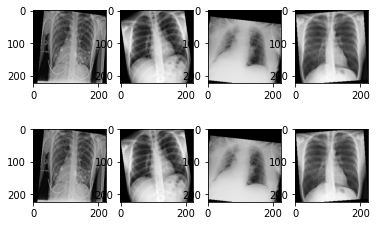

In [38]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2,4) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(batch_x[0])
axarr[0,1].imshow(batch_x[1])
axarr[0,2].imshow(batch_x[2])
axarr[0,3].imshow(batch_x[3])
axarr[1,0].imshow(batch_x[0])
axarr[1,1].imshow(batch_x[1])
axarr[1,2].imshow(batch_x[2])
axarr[1,3].imshow(batch_x[3])

In [39]:
batch_x, batch_y = next(test_generator)

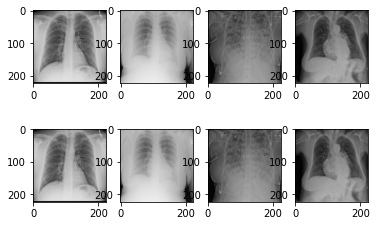

In [40]:
f, axarr = plt.subplots(2,4) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(batch_x[0])
axarr[0,1].imshow(batch_x[1])
axarr[0,2].imshow(batch_x[2])
axarr[0,3].imshow(batch_x[3])
axarr[1,0].imshow(batch_x[0])
axarr[1,1].imshow(batch_x[1])
axarr[1,2].imshow(batch_x[2])
axarr[1,3].imshow(batch_x[3])

## Thank You!

## Further reading

**Documentation for objects used in this notebook**

[Keras Sequence documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

[Keras ImageDataGenerator for data augmentation documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

[More sophisticated data augmentation tool](https://imgaug.readthedocs.io/en/latest/)

**Guides**

[tensorflow guide: data](https://www.tensorflow.org/guide/data)

[OpenCV tutorials](https://docs.opencv.org/master/d9/df8/tutorial_root.html)

[Data Augmentation survey](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0)
